In [7]:
# import the neccessary dependacies we will use by default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder

Some insights into this project:
- The category of machine learning models that these fall into is _supervised learning_. Supervised learning is a type of machine learning where the model is trained on labeled data. The label in this case is the method of data breach.

The models that will be tested out will fall into the following category of machine learning:
* <u><b>Logistic Regression</b></u>: This is a supervised Learning that can be used to predict a categorical outcome. In this case, the categorical outcome is the method of the data breach. The features that will be used are: entity, year, records and organization type.
* <u><b>Decision Trees</b></u>: This is another supervised learning algorithm that can be used to predict a categorical outcome. Decision trees work by creating a tree-like structure that represents the relationships between the features and the outcomes.
* <u><b>Support Vector Machine(SVMs):</u></b> This is a supervised learning algorithm that can be used to predict both categorical and continous outcomes. SVMs work by finding the hyperplane that best seperates the data points into different classes.
* <u><b>Random Forests</u></b> This is an ensemble learning algorithm that combines multiple decision trees to improve the accuracy of the predictions.
* <u><b>Neural Networks</u></b> This is a more complex algorithm that can be used to predict both categorical and continuous outcomes. Neural Networks work by learning the relationships between the features and the outcome through a process called backpropogation.

In [8]:
# load the dataset(s) we will be using
csv_file_path = os.path.abspath('df_1.csv');  # get the absolute path of the CS

df = pd.read_csv(csv_file_path);   # Read the CSV file into a datafram
# display the head to see if the dataset works as intended
df.head(10)  #adjust the parameter value as needed

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6]
1,1,500px,2020,14870304,social networking,hacked,[7]
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9]
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10]
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12]
5,5,Advocate Medical Group,2017,4000000,healthcare,lost / stolen media,[13][14]
6,6,AerServ (subsidiary of InMobi),2018,75000,advertising,hacked,[15]
7,7,"Affinity Health Plan, Inc.",2013,344579,healthcare,lost / stolen media,[16][17]
8,8,Airtel,2019,320000000,telecommunications,poor security,[18]
9,9,Air Canada,2018,20000,transport,hacked,[19]


From my exploration, I discovered that dataframe 3 and dataframe 1 are the same, so merging them would be useless, dataframe 2 is different from dataframe 1, therefore, merging them holds some value.

In [9]:
df.dtypes  # simply lists out the datatype we are working with

Unnamed: 0            int64
Entity               object
Year                 object
Records              object
Organization type    object
Method               object
Sources              object
dtype: object

In [10]:
df.columns # observe the column list

Index(['Unnamed: 0', 'Entity', 'Year', 'Records', 'Organization type',
       'Method', 'Sources'],
      dtype='object')

In [11]:
# we will need to rename the unnamed column
df.rename(columns={'Unnamed: 0' : 'Index'}, inplace=True)

In [12]:
# Test out the number of unique values contained in Entity
len(df['Entity'].unique())   #there's a total of 331 unique name for comapnies

331

Regarding the column __Entity__, there's 2 options in terms of data preprocessing:
* Drop the column altogether
* Apply Hashing

In [13]:
import hashlib

#create a hash function
def hash_function(text):
    return hashlib.sha256(text.encode()).hexdigest()

# create a new column for the hashed values
df['hashed_Entity'] = df['Entity'].apply(hash_function)

#observe the hashed column
df.head()  # we have the hashed entity

,Index,Entity,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,500px,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...


In [14]:
# create a copy of the dataframe and drop the Entity column 
df_copy1 = df.drop(columns={'Entity'})

In [15]:
df_copy1  # we don't want to make modifications to the original dataframe 

,Index,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...
...,...,...,...,...,...,...,...
347,347,2019,173000000,social network,hacked,[406][407],637e6be11e5f556343bad0073ff64ddcf396a88cec35d7...
348,348,2020,200000000,financial,accidentally published,[408],985ee128022c38982d1de4c4173f538ced9151f0517fe9...
349,349,2020,391250,healthcare,poor security,[409],869ada24f3639cb94ed2dd22ec15aca5928cb7b7c0bc28...
350,350,2022,6400000,various,poor security,[410] [411],89def538702db6ab06b39b1d28f5f7980de01dd04bd0a0...


In [16]:
len(df_copy1['Organization type'].unique())   # in terms of organization type, there's 70 different unique values
df_copy1

,Index,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...
...,...,...,...,...,...,...,...
347,347,2019,173000000,social network,hacked,[406][407],637e6be11e5f556343bad0073ff64ddcf396a88cec35d7...
348,348,2020,200000000,financial,accidentally published,[408],985ee128022c38982d1de4c4173f538ced9151f0517fe9...
349,349,2020,391250,healthcare,poor security,[409],869ada24f3639cb94ed2dd22ec15aca5928cb7b7c0bc28...
350,350,2022,6400000,various,poor security,[410] [411],89def538702db6ab06b39b1d28f5f7980de01dd04bd0a0...


In [17]:
# remove the special characters
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(',', '_')  # replace the cases of ',' with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(' ', '_') # we also replace the cases of spacing with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace('__', '_')  # replace all instances of __ with _

Before encoding the organization type, I've copied the df to keep the original data intact. I'm dropping the hashed_Entity column as it is not needed for visualizing – we want to focus on industries and not individual companies.

In [18]:
df_vis = df_copy1  #create another copy of the df_copy and perform further data preprocessing
#drop the hashed entity column
df_vis.drop(columns={'hashed_Entity'}, inplace=True)  #note: after dropping the column the first time, you may end up running into an error if you were to rerun the code block again
df_vis

,Index,Year,Records,Organization type,Method,Sources
0,0,2016,2200000,healthcare,hacked,[5][6]
1,1,2020,14870304,social_networking,hacked,[7]
2,2,2020,175350,healthcare,poor security,[8][9]
3,3,2013,152000000,tech,hacked,[10]
4,4,2019,7500000,tech,poor security,[11][12]
...,...,...,...,...,...,...
347,347,2019,173000000,social_network,hacked,[406][407]
348,348,2020,200000000,financial,accidentally published,[408]
349,349,2020,391250,healthcare,poor security,[409]
350,350,2022,6400000,various,poor security,[410] [411]


Checking if the Year column is well formatted (should be a year like 2016, or 2019, not 2016-2019). If not, we'll need to do some data cleaning.

In [19]:
#Check if any value in the year column is null
print("Null values: ", df_vis['Year'].isnull().values.any())  # there are no null values in the year column

#Check if any value in the year column is not well formatted (i.e. not a number)
print("Non numeric values: ", df_vis['Year'].str.isnumeric().values.any())  # there are values that are not numeric

#print out all the values in the year column that are not numeric
print("Non numeric values:")
df_vis[~df_vis['Year'].str.isnumeric()]  # as we can see, the three columns that have non-numeric values are in index 94 96 and 144

Null values:  False
Non numeric values:  True
Non numeric values:


,Index,Year,Records,Organization type,Method,Sources
94,94,2019-2020,"9,000,000 (approx) - basic booking, 2208 (cred...",transport,hacked,[119][120]
96,96,2018-2019,2000000,restaurant,hacked,[122]
144,144,2014 and 2015,363000,hotel,hacked,[194][195]


In [20]:
#having index and the dataframe indexing is redundant
df_vis.drop('Index', inplace=True, axis=1)

In [21]:
#observe the dataset to see if the colum index has been successfully dropped
df_vis  # as we can see, the column index has been successfully dropped

,Year,Records,Organization type,Method,Sources
0,2016,2200000,healthcare,hacked,[5][6]
1,2020,14870304,social_networking,hacked,[7]
2,2020,175350,healthcare,poor security,[8][9]
3,2013,152000000,tech,hacked,[10]
4,2019,7500000,tech,poor security,[11][12]
...,...,...,...,...,...
347,2019,173000000,social_network,hacked,[406][407]
348,2020,200000000,financial,accidentally published,[408]
349,2020,391250,healthcare,poor security,[409]
350,2022,6400000,various,poor security,[410] [411]


There are 3 values in the Year column that are not well formed – we also will need to fix the Records column for similar formatting issues.

In [22]:
'''
Modify df_vis:
for each value in the year column that is not numeric:
    record the last year listed in the year column (i.e. the last 4 characters)
    record the first year listed in the year column (i.e. the first 4 characters)
change the year column of this entry to the first 4 characters (the first year)
for each year between the first year and the last year:
    add a new entry to the dataframe with the same values as the entry that was changed, except for the year column, which will be the year in question
'''
last_row_index = df_vis.tail(1).index[0]
# Create an empty list to store modified rows
new_rows = []

# Iterate through the DataFrame
for index, row in df_vis.iterrows():
    year_value = row['Year']
    
    # Check if the year is not numeric
    if not year_value.isnumeric():
        # Extract the first and last year
        first_year = int(year_value[:4])
        last_year = int(year_value[-4:])

        # Change the year column to the first year
        df_vis.loc[index, 'Year'] = str(first_year)
        
        #Create new rows for each year between the first and last year
        for year in range(first_year + 1, last_year + 1):
            last_row_index+=1 # Increment the index of the last row
            new_row = row.copy()  # Create a copy of the current row
            new_row['Year'] = str(year)
            new_row['Index'] = last_row_index
            new_rows.append(new_row) # Append the new row to the list

# Concatenate the new rows with the original DataFrame
new_rows_df = pd.DataFrame(new_rows)

df_vis = pd.concat([df_vis, new_rows_df], ignore_index=True)

#essentially, rather than having multiple year, it was replaced by the first year that pops up.
df_vis

,Year,Records,Organization type,Method,Sources,Index
0,2016,2200000,healthcare,hacked,[5][6],NaN
1,2020,14870304,social_networking,hacked,[7],NaN
2,2020,175350,healthcare,poor security,[8][9],NaN
3,2013,152000000,tech,hacked,[10],NaN
4,2019,7500000,tech,poor security,[11][12],NaN
...,...,...,...,...,...,...
350,2022,6400000,various,poor security,[410] [411],NaN
351,2022,95000,retail,accidentally published,[412],NaN
352,2020,"9,000,000 (approx) - basic booking, 2208 (cred...",transport,hacked,[119][120],352.0
353,2019,2000000,restaurant,hacked,[122],353.0


The Year's column is fixed, but I suspect this approach may be exaggerating the number of breaches in 2019.
Instead, I will fix the Records column, and then split (divide?) the number of records by the number of years the breach lasted.


In [23]:
df_vis['Organization type'].unique()   

array(['healthcare', 'social_networking', 'tech', 'advertising',
       'telecommunications', 'transport', 'web', 'financial', 'gaming',
       'tech_retail', 'telecoms', 'dating', 'government', 'academic',
       'retail', 'educational_services', 'gambling', 'banking', 'game',
       'energy', 'background_check', 'information_technology',
       'hosting_provider', 'military', 'health', 'consulting_accounting',
       'political', 'messaging_app', 'restaurant',
       'financial_credit_reporting', 'data_broker', 'social_network',
       'financial_service_company', 'Information_Security',
       'personal_and_demographic_data_about_residents_and_their_properties_of_US',
       'hotel', 'humanitarian', 'special_public_corporation', 'shopping',
       'local_search', 'mobile_carrier', 'publisher_(magazine)',
       'government_healthcare', 'software', 'web_military',
       'online_shopping', 'genealogy', 'media', 'telecom',
       'QR_code_payment', 'fashion', 'Clinical_Laboratory',
  

In [24]:
le = LabelEncoder()  #perform label encoding on the organization_type, the copy of df_vis

# implement label encoding on the Organization type column
le.fit(df_vis['Organization type'])   # fit the data we want to train the encoder on
df_vis['Organization type'] = le.transform(df_vis['Organization type'])
# observe how the column 'Organization Type' has changed
df_vis.head()

,Year,Records,Organization type,Method,Sources,Index
0,2016,2200000,30,hacked,[5][6],NaN
1,2020,14870304,53,hacked,[7],NaN
2,2020,175350,30,poor security,[8][9],NaN
3,2013,152000000,56,hacked,[10],NaN
4,2019,7500000,56,poor security,[11][12],NaN


In [25]:
df_vis.dtypes   # as we can see, the Organization type changed from Object --> integer datatype

Year                  object
Records               object
Organization type      int32
Method                object
Sources               object
Index                float64
dtype: object

In [26]:
# observe the label frequency, to gain an understanding of outliers and inlier values
df_vis['Organization type'].value_counts()    # some values to note: 7 repeats 13 times, 18 repeats 38  times, 23 repeats 12 times, 25 repeats 30 times, 30 repeats 47 times, 49 repeats 27 times.

65    53
30    47
18    38
25    30
49    27
      ..
14     1
47     1
11     1
54     1
64     1
Name: Organization type, Length: 70, dtype: int64

In [27]:
df_vis['Method']  # we will also need to perform label encoding on the method section

0                      hacked
1                      hacked
2               poor security
3                      hacked
4               poor security
                ...          
350             poor security
351    accidentally published
352                    hacked
353                    hacked
354                    hacked
Name: Method, Length: 355, dtype: object

In [28]:
df_vis['Method'].unique()

array(['hacked', 'poor security', 'lost / stolen media',
       'accidentally published', 'inside job, hacked',
       'lost / stolen computer', 'unknown', 'unsecured S3 bucket',
       'inside job', nan, 'accidentally uploaded',
       'poor security / hacked', 'Poor security', 'unprotected api',
       'poor security/inside job', 'data exposed by misconfiguration',
       'zero-day vulnerabilities', 'intentionally lost',
       'misconfiguration/poor security', 'ransomware hacked',
       'rogue contractor', 'improper setting, hacked',
       'hacked/misconfiguration',
       'publicly accessible Amazon Web Services (AWS) server',
       'accidentally exposed', 'social engineering'], dtype=object)

In [29]:
""# seems like the method column contains certain NaN values and certain Unknown values, we will need to determine whether we replace such values or drop them in its entirety
df_vis['Method'].value_counts()     

hacked                                                  195
poor security                                            43
lost / stolen media                                      33
accidentally published                                   21
inside job                                               19
lost / stolen computer                                   16
unknown                                                   7
improper setting, hacked                                  2
poor security/inside job                                  2
intentionally lost                                        1
accidentally exposed                                      1
publicly accessible Amazon Web Services (AWS) server      1
hacked/misconfiguration                                   1
rogue contractor                                          1
ransomware hacked                                         1
misconfiguration/poor security                            1
unprotected api                         

In [30]:
#check which columns have null/unknoown values
null_mask = df_vis.isnull().any(axis=1)
null_rows=df_vis[null_mask]

print(null_rows)

     Year    Records  Organization type                  Method      Sources  \
0    2016    2200000                 30                  hacked       [5][6]   
1    2020   14870304                 53                  hacked          [7]   
2    2020     175350                 30           poor security       [8][9]   
3    2013  152000000                 56                  hacked         [10]   
4    2019    7500000                 56           poor security     [11][12]   
..    ...        ...                ...                     ...          ...   
347  2019  173000000                 52                  hacked   [406][407]   
348  2020  200000000                 18  accidentally published        [408]   
349  2020     391250                 30           poor security        [409]   
350  2022    6400000                 64           poor security  [410] [411]   
351  2022      95000                 49  accidentally published        [412]   

     Index  
0      NaN  
1      NaN  


In [31]:
#drop sources and index
df_vis.drop(columns=['Index', 'Sources'], axis=1, inplace=True)     # drop the index and sources
df_vis.drop(352)  # this will drop the outlier value

,Year,Records,Organization type,Method
0,2016,2200000,30,hacked
1,2020,14870304,53,hacked
2,2020,175350,30,poor security
3,2013,152000000,56,hacked
4,2019,7500000,56,poor security
...,...,...,...,...
349,2020,391250,30,poor security
350,2022,6400000,64,poor security
351,2022,95000,49,accidentally published
353,2019,2000000,48,hacked


In [32]:
"""Two changes needs to be made regarding the method column
    1. Replace the "Unknown" value with the most frequently repeated word
    2. Drop any NaN values if it exists
"""
most_frequent_word = df_vis['Method'].value_counts().index[0]
#replace all occurences of "Unknown" with "Hacked"
df_vis['Method'].replace('unknown', most_frequent_word, inplace=True)
# drop any NaN values
df_vis.dropna(inplace=True)
# Print the dataframe
df_vis.dtypes  # as we can see, we will need to convert all the colummns here into numerical datatypes

Year                 object
Records              object
Organization type     int32
Method               object
dtype: object

In [33]:
# let's verify if the method column contains any nan/null values
df_vis.isnull().all()   # seems that none of the values here contain any more null values, as we can see none of the datatype has any null values now

Year                 False
Records              False
Organization type    False
Method               False
dtype: bool

In [34]:
print(list(df_vis['Method'].unique()))   # based on the list, we can see that the Method column doesn't contain unknown anymore.
list(df_vis['Method'].value_counts())   # we also gain insight into the frequency of the methods being repeated, there's 24 methods, therefore, the label encoding will range from 0-23

['hacked', 'poor security', 'lost / stolen media', 'accidentally published', 'inside job, hacked', 'lost / stolen computer', 'unsecured S3 bucket', 'inside job', 'accidentally uploaded', 'poor security / hacked', 'Poor security', 'unprotected api', 'poor security/inside job', 'data exposed by misconfiguration', 'zero-day vulnerabilities', 'intentionally lost', 'misconfiguration/poor security', 'ransomware hacked', 'rogue contractor', 'improper setting, hacked', 'hacked/misconfiguration', 'publicly accessible Amazon Web Services (AWS) server', 'accidentally exposed', 'social engineering']


[201, 43, 33, 20, 19, 16, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [35]:
# prior to implementing label encoding, we will need to clear up the string of some grammatical issues that will cause mismatched data when we train the model otherwise
# we want uniformity for the data input values
# convert all uppercase letters to lowercase
df_vis['Method'] = df_vis['Method'].str.lower()

# replace all spaces with "_"
df_vis['Method'] = df_vis['Method'].str.replace(' ', '_')

# replace all slash signs with "_"
df_vis['Method'] = df_vis['Method'].str.replace('/', '_')

# replace all __ and ___ with _
df_vis['Method'] = df_vis['Method'].str.replace('___', '_')
df_vis['Method'] = df_vis['Method'].str.replace('__', '_')

# check the updated dataframe
list(df_vis['Method'].unique())

['hacked',
 'poor_security',
 'lost_stolen_media',
 'accidentally_published',
 'inside_job,_hacked',
 'lost_stolen_computer',
 'unsecured_s3_bucket',
 'inside_job',
 'accidentally_uploaded',
 'poor_security_hacked',
 'unprotected_api',
 'poor_security_inside_job',
 'data_exposed_by_misconfiguration',
 'zero-day_vulnerabilities',
 'intentionally_lost',
 'misconfiguration_poor_security',
 'ransomware_hacked',
 'rogue_contractor',
 'improper_setting,_hacked',
 'hacked_misconfiguration',
 'publicly_accessible_amazon_web_services_(aws)_server',
 'accidentally_exposed',
 'social_engineering']

In [36]:
# now the method column is ready for label encoding preprocessing, since we already called on the label encoder previously, we can reuse it
le.fit(df_vis['Method'])  # train the label encoder on the column data we want to train
df_vis['Method'] = le.transform(df_vis['Method'])
df_vis.drop(352, inplace=True)   # row 352 had an visible outlier value

In [37]:
#now that everything has been converted in the form of numbers, we can now convert all the datatype into numerical values
df_vis['Year'] = pd.to_numeric(df_vis['Year'])   # convert the year column into numerical datatype
#df_vis['Records'] = pd.to_numeric(df_vis['Records'])  # convert the Records column into numerical datatype -->> requires further cleanup
df_vis['Organization Type'] = pd.to_numeric(df_vis['Organization type'])  # convert the organization type where label encoding was made into numerical datatype
df_vis['Method'] = pd.to_numeric(df_vis['Method'])   # convert the method column where label encoding was also implemented into numerical datatype

df_vis.dtypes   # observe the  datatypes of the dataframe after the changes have taken place

Year                  int64
Records              object
Organization type     int32
Method                int32
Organization Type     int32
dtype: object

In [38]:
# check all the unique values in records
#print(df_vis['Records'].unique())
#manually added all the non-numerical values in a list to replace them with randomized values
string_based_characters = ["unknown", "millions", "tens of thousands", "over 5,000,000", "G20 world leaders", "19 years of data", "63 stores", "350 clients emails", "unknown (client list)", "Source Code Compromised", "TBC", "2.5GB", "Unknown", "undisclosed", "100 terabytes", "8 locations", "51 locations", "500 locations", "9,000,000 (approx) - basic booking, 2208 (credit card details)", "54 locations", "250 locations", "10 locations", "93 stores", "200 stores", "235 GB"]

#lets write some functions 
#create a function to randomly select a numerical value from the given range
def random_numerical_value(min_value, max_value):
    """Randomly select a numerical value from the given range."""
    random_value = np.random.randint(min_value, max_value + 1)
    return random_value

#apply the function to the 'Records' column, replacing the non-numerical values with the numerical values
def replace_non_numerical_values(df, string_based_characters, min_value, max_value):
    
    """Replace all instance of non-numerical values in the given column of the given dataframe with the random numerical values from the given range"""
    
    for character in string_based_characters:
        df['Records'] = df['Records'].replace(character, random_numerical_value(min_value, max_value))  # call on the previous function
    return df


#create 2 copy of df_vis
df_vis1 = df_vis
df_vis2 = df_vis
#replace the non_numerical values in the records_column of the Dataframe with numerical values
df_vis1 = replace_non_numerical_values(df_vis, string_based_characters, 100000, 10000000)
df_vis1['Records'].unique()   #  onserve that the dataframe column 'Records' does not have any more string based data, meaning we can now convert it into numerical data


array(['2200000', '14870304', '175350', '152000000', '7500000', '4000000',
       '75000', '344579', '320000000', '20000', 4884932, '200000',
       '300000', '46000000', '156000', '80000000', '92000000', '20000000',
       '2400000', '12367232', '275000', '91000', '32000000', '113000',
       '114000', '18000000', 9472490, 4729982, '125000', '1220000',
       '250000', '12500000', '1200000', 7181075, '1900000', '100000',
       '35040000', '2300000', '7633234', '14000000', '1023209', '90000',
       '500000', 1179529, 7150645, '800000', '140000000', '350000',
       '106000000', '40000000', '9400000', '1100000', '60000', '110000',
       '5000000', '56000000', '6000000', '10000000', '3900000', '360083',
       '150000', '160000', 6305687, '105470', '4500000', '55000000',
       '1000000', '2600000', '2500000', '40000', 8430598, '1107034',
       '8637405', '8000000', 6919469, 3479159, '30000', '9700000',
       '600000', '4900000', '3000000', '68648009', '1400000', '162000000',
      

In [39]:
# approach 2 is to simply drop the rows that contains such non-numerical data completely
def drop_rows_with_non_numerical_values(df, string_based_characters):
    """Drop any rows with all instances of non-nnumerical values in the given column of the given dataframe"""
    
    for character in string_based_characters:
        df = df[df['Records'].str.contains(character) == False]
    return df

# drop any rows with all instances of non-numerical values in the 'Records' column of the dataframe
df_vis2 = drop_rows_with_non_numerical_values(df_vis2, string_based_characters)        # we want the changes to take place in df_vis2 rather than df_vis1 where we replaced it with numerical values instead of dropping them
df_vis2['Records'].unique()   # observe that there's no string values within this dataset either

C:\Users\dasa7\AppData\Local\Temp\ipykernel_7840\1229512378.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df['Records'].str.contains(character) == False]


array(['2200000', '14870304', '175350', '152000000', '7500000', '4000000',
       '75000', '344579', '320000000', '20000', '200000', '300000',
       '46000000', '156000', '80000000', '92000000', '20000000',
       '2400000', '12367232', '275000', '91000', '32000000', '113000',
       '114000', '18000000', '125000', '1220000', '250000', '12500000',
       '1200000', '1900000', '100000', '35040000', '2300000', '7633234',
       '14000000', '1023209', '90000', '500000', '800000', '140000000',
       '350000', '106000000', '40000000', '9400000', '1100000', '60000',
       '110000', '5000000', '56000000', '6000000', '10000000', '3900000',
       '360083', '150000', '160000', '105470', '4500000', '55000000',
       '1000000', '2600000', '2500000', '40000', '1107034', '8637405',
       '8000000', '30000', '9700000', '600000', '4900000', '3000000',
       '68648009', '1400000', '162000000', '145000000', '2000000',
       '3300000', '514330', '108000000', '251000', '180111', '315000',
       '

In [40]:
# now convert the datatype of both df_vis1 and df_vis2
df_vis1['Records'] = pd.to_numeric(df_vis1['Records'])
df_vis2['Records'] = pd.to_numeric(df_vis2['Records'])

#observe the newly created datasets
print("df_vis1: \n \n", df_vis1.dtypes, "\n")
print("df_vis2: \n \n", df_vis2.dtypes, "\n")

#as we can see all our data has been converted into numerical datatypes successfully

df_vis1: 
 
 Year                 int64
Records              int64
Organization type    int32
Method               int32
Organization Type    int32
dtype: object 

df_vis2: 
 
 Year                 int64
Records              int64
Organization type    int32
Method               int32
Organization Type    int32
dtype: object 



__Note__: Regarding the difference between df_vis1 and df_vis2, both of whom are copies of df_vis, df_vis1 has it's 'Records' column altered by replacing the non-numerical values with randomized value between 100,000 and 10000000 and df_vis2 had it's non-numerical values in the 'Records' column simply dropped, the goal is to now split the data in various forms and see how their performance is affected.

From here onwards, we will be dealing with modeling and data preprocessing

Linux command to install sickit-learn and pytorch: 
` sudo apt install python3-scipy torch torchvision torchaudio`, but for general jupyter notebook use, simply run the code cell below

In [41]:
#continue here  --> https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

#import the neccessary components we will need to train the model
!pip3 install scipy
!pip3 install torch torchvision torchaudio

Epoch 1/1000 - MSE: 60.7783
Epoch 2/1000 - MSE: 60.5425
Epoch 3/1000 - MSE: 60.3013
Epoch 4/1000 - MSE: 60.0480
Epoch 5/1000 - MSE: 59.7780
Epoch 6/1000 - MSE: 59.4979
Epoch 7/1000 - MSE: 59.2125
Epoch 8/1000 - MSE: 58.9111
Epoch 9/1000 - MSE: 58.5841
Epoch 10/1000 - MSE: 58.2242
Epoch 11/1000 - MSE: 57.8272
Epoch 12/1000 - MSE: 57.3835
Epoch 13/1000 - MSE: 56.8651
Epoch 14/1000 - MSE: 56.2917
Epoch 15/1000 - MSE: 55.6924
Epoch 16/1000 - MSE: 55.0748
Epoch 17/1000 - MSE: 54.4374
Epoch 18/1000 - MSE: 53.7759
Epoch 19/1000 - MSE: 53.0841
Epoch 20/1000 - MSE: 52.3581
Epoch 21/1000 - MSE: 51.5915
Epoch 22/1000 - MSE: 50.7859
Epoch 23/1000 - MSE: 49.9394
Epoch 24/1000 - MSE: 49.0497
Epoch 25/1000 - MSE: 48.1181
Epoch 26/1000 - MSE: 47.1428
Epoch 27/1000 - MSE: 46.1279
Epoch 28/1000 - MSE: 45.0786
Epoch 29/1000 - MSE: 43.9962
Epoch 30/1000 - MSE: 42.8836
Epoch 31/1000 - MSE: 41.7433
Epoch 32/1000 - MSE: 40.5794
Epoch 33/1000 - MSE: 39.3959
Epoch 34/1000 - MSE: 38.1950
Epoch 35/1000 - MSE: 36

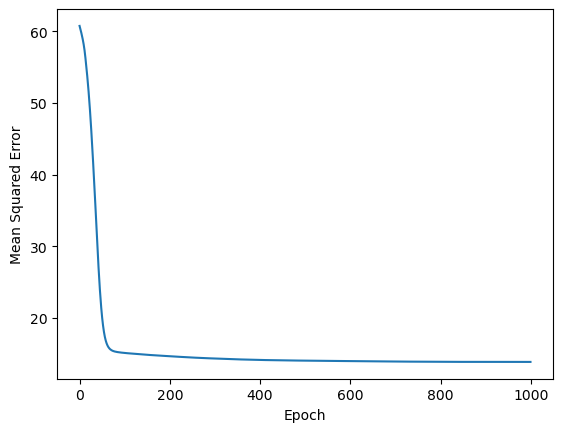

Year                      2019
Records              100000000
Organization type           35
Name: 159, dtype: int64 -> [7.659182] (expected [20.])
Year                    2020
Records              4000000
Organization type         51
Name: 345, dtype: int64 -> [7.4524064] (expected [13.])
Year                   2010
Records              260000
Organization type        39
Name: 318, dtype: int64 -> [6.645391] (expected [7.])
Year                   2015
Records              680000
Organization type        25
Name: 236, dtype: int64 -> [5.293837] (expected [7.])
Year                    2010
Records              2600000
Organization type         18
Name: 157, dtype: int64 -> [6.251443] (expected [11.])
Year                  2007
Records              89000
Organization type       25
Name: 276, dtype: int64 -> [7.898335] (expected [7.])
Year                    2008
Records              2200000
Organization type          7
Name: 307, dtype: int64 -> [6.8345785] (expected [11.])
Year         

In [62]:
#import the neccessary components
from copy import deepcopy  # this needed to be adjusted
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#read the dataframes --> df_vis1 and df_vis2
#split the data as needed
features1 = ['Year', 'Records', 'Organization type']  # on one instance, we will utilize Method as label
label1 = 'Method'
features2 = ['Year', 'Method', 'Organization type']  # on the other instance, we will utilize Records as label
label2 = 'Records'

# first variation of data we are working with --> each of them will be split into 3 ways: 75 to 25, 50 to 50 and 90 to 10
X1 = df_vis1[features1]
y1 = df_vis1[label1]

#second variation of data we are working with --> each of them will be split into 3 ways: 75 to 25, 50 to 50, 90 to 10
X2 = df_vis1[features2]
y2 = df_vis1[label2]

#third variation of data we are working with --> each of them will be split into 3 ways: 
X3 = df_vis2[features1]
y3 = df_vis2[label1]

#4th variation of data we are working with
X4 = df_vis2[features2]
y4 = df_vis2[label2]

#now split the data into three kinds, 75:25, 50:50 and 90:10 for train to test ratio
X_train1_75_raw, X_test1_25_raw, y_train1_75_raw, y_test1_25_raw = train_test_split(X1, y1, test_size=0.25, random_state=42, shuffle=True)
X_train1_50_raw, X_test1_50_raw, y_train1_50_raw, y_test1_50_raw = train_test_split(X1, y1, test_size=0.5, random_state=1234, shuffle=True)
X_train1_90_raw, X_test1_10_raw, y_train1_90_raw, y_test1_10_raw = train_test_split(X1, y1, test_size=0.1, random_state=1, shuffle=True)

X_train2_75_raw, X_test2_25_raw, y_train2_75_raw, y_test2_25_raw = train_test_split(X2, y2, test_size=0.25, random_state=42, shuffle=True)
X_train2_50_raw, X_test2_50_raw, y_train2_50_raw, y_test2_50_raw = train_test_split(X2, y2, test_size=0.5, random_state=1234, shuffle=True)
X_train2_90_raw, X_test2_10_raw, y_train2_90_raw, y_test2_10_raw = train_test_split(X2, y2, test_size=0.1, random_state=1, shuffle=True)

X_train3_75_raw, X_test3_25_raw, y_train3_75_raw, y_test3_25_raw = train_test_split(X3, y3, test_size=0.25, random_state=42, shuffle=True)
X_train3_50_raw, X_test3_50_raw, y_train3_50_raw, y_test3_50_raw = train_test_split(X3, y3, test_size=0.5, random_state=1234, shuffle=True)
X_train3_90_raw, X_test3_10_raw, y_train3_90_raw, y_test3_10_raw = train_test_split(X3, y3, test_size=0.1, random_state=1, shuffle=True)

X_train4_75_raw, X_test4_25_raw, y_train4_75_raw, y_test4_25_raw = train_test_split(X4, y4, test_size=0.25, random_state=42, shuffle=True)
X_train4_50_raw, X_test4_50_raw, y_train4_50_raw, y_test4_50_raw = train_test_split(X4, y4, test_size=0.5, random_state=1234, shuffle=True)
X_train4_90_raw, X_test4_10_raw, y_train4_90_raw, y_test4_10_raw = train_test_split(X4, y4, test_size=0.1, random_state=1, shuffle=True)

# standardizze the data, we will need to do this for all 12 data splits we have made
# standardize the first split
scaler = StandardScaler()
scaler.fit(X_train1_75_raw)
X_train1_75 = scaler.transform(X_train1_75_raw)
X_test1_25 = scaler.transform(X_test1_25_raw)

#standardize the second split
scaler.fit(X_train1_50_raw)
X_train1_50 = scaler.transform(X_train1_50_raw)
X_test1_50 = scaler.transform(X_test1_50_raw)

# standardize the third split
scaler.fit(X_train1_90_raw)
X_train1_90 = scaler.transform(X_train1_90_raw)
X_test1_10 = scaler.transform(X_test1_10_raw)

#standarize the 4th split
scaler.fit(X_train2_75_raw)
X_train2_75 = scaler.transform(X_train2_75_raw)
X_test2_25 = scaler.transform(X_test2_25_raw)

# standardize the 5th split
scaler.fit(X_train2_50_raw)
X_train2_50 = scaler.transform(X_train2_50_raw)
X_test2_50 = scaler.transform(X_test2_50_raw)

#standarize the 6th split
scaler.fit(X_train2_90_raw)
X_train2_90 = scaler.transform(X_train2_90_raw)
X_test2_10 = scaler.transform(X_test2_10_raw)

#standardize the 7th split
scaler.fit(X_train3_75_raw)
X_train3_75 = scaler.transform(X_train3_75_raw)
X_test3_25 = scaler.transform(X_test3_25_raw)

#standardize the 8th split
scaler.fit(X_train3_50_raw)
X_train3_50 = scaler.transform(X_train3_50_raw)
X_test3_50 = scaler.transform(X_test3_50_raw)

# standardize the 9th split
scaler.fit(X_train3_90_raw)
X_train3_90 = scaler.transform(X_train3_90_raw)
X_test3_10 = scaler.transform(X_test3_10_raw)

# convert to 2D PyTorch sensors
"""
    Some insights regarding why Tensors are important when it comes to training models in pytorch
    
    Tensors are fundamental data structure in pyTorch. They are used to represent all kinds of data, including inputs, outputs and parameters of models. Tensors are similar to Numpy arrays but they have several advantages:
    
    - Tensors can run on GPUs: PyTorch can automatically move tensors to the GPU for acceleration. This can lead to significant performance improvements, especially for large models and datasets
    - Tensors are optimized for automatic differentiation. PyTorch's autograd library can automatically compute the gradients of tensors with respect to each other. This is essential for training neural networks using gradient descent.
    - Tensors have a rich set of mathematical operations: PyTorch provides a wide range of operations for tensors, including linear algebra, convolution, and pooling. This makes it easy to implement complex models in PyTorch
"""
# again, we will need to do this for all 9 splits in our case

# 2d pytorch tensor for 1st split
X_train1_75 = torch.tensor(X_train1_75, dtype=torch.float32)  
y_train1_75 = torch.tensor(y_train1_75_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)  #if you don't add to_numpy() next to the training datasets that are of type series, the console will throw an error
X_test1_25 = torch.tensor(X_test1_25, dtype=torch.float32)
y_test1_25 = torch.tensor(y_test1_25_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

#2d pytorch tensor for 2nd split
X_train1_50 = torch.tensor(X_train1_50, dtype=torch.float32)  
y_train1_50 = torch.tensor(y_train1_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test1_50 = torch.tensor(X_test1_50, dtype=torch.float32)
y_test1_50 = torch.tensor(y_test1_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for 3rd split
X_train1_90 = torch.tensor(X_train1_90, dtype=torch.float32)  
y_train1_90 = torch.tensor(y_train1_90_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test1_10 = torch.tensor(X_test1_10, dtype=torch.float32)
y_test1_10 = torch.tensor(y_test1_10_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for 4th split
X_train2_75 = torch.tensor(X_train2_75, dtype=torch.float32)  
y_train2_75 = torch.tensor(y_train2_75_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test2_25 = torch.tensor(X_test2_25, dtype=torch.float32)
y_test2_25 = torch.tensor(y_test2_25_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 5th split
X_train2_50 = torch.tensor(X_train2_50, dtype=torch.float32)  
y_train2_50 = torch.tensor(y_train2_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test2_50 = torch.tensor(X_test2_50, dtype=torch.float32)
y_test2_50 = torch.tensor(y_test2_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 6th split
X_train2_90 = torch.tensor(X_train2_90, dtype=torch.float32)  
y_train2_90 = torch.tensor(y_train2_90_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test2_10 = torch.tensor(X_test2_10, dtype=torch.float32)
y_test2_10 = torch.tensor(y_test2_10_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 7th split
X_train3_75 = torch.tensor(X_train3_75, dtype=torch.float32)  
y_train3_75 = torch.tensor(y_train3_75_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test3_25 = torch.tensor(X_test3_25, dtype=torch.float32)
y_test3_25 = torch.tensor(y_test3_25_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 8th split
X_train3_50 = torch.tensor(X_train3_50, dtype=torch.float32)  
y_train3_50 = torch.tensor(y_train3_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test3_50 = torch.tensor(X_test3_50, dtype=torch.float32)
y_test3_50 = torch.tensor(y_test3_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 9th split
X_train3_90 = torch.tensor(X_train3_90, dtype=torch.float32)  
y_train3_90 = torch.tensor(y_train3_90_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test3_10 = torch.tensor(X_test3_10, dtype=torch.float32)
y_test3_10 = torch.tensor(y_test3_10_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# define the neural network that will be used for regression based analysis
model = nn.Sequential(
    nn.Linear(3, 24),  # adjusted input size to 3
    nn.ReLU(),
    nn.Linear(24,12),
    nn.ReLU(),
    nn.Linear(12,6),
    nn.ReLU(),
    nn.Linear(6,1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # this will calculate the mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000  # number of epochs to run the model, adjust this number as needed: 100, 10000, 10 etc.
batch_size = 10  # size of each batch
batch_start1 = torch.arange(0, len(X_train1_75), batch_size)
batch_start2 = torch.arange(0, len(X_train1_50), batch_size)
batch_start3 = torch.arange(0, len(X_train1_90), batch_size)
batch_start4 = torch.arange(0, len(X_train2_75), batch_size)
batch_start5 = torch.arange(0, len(X_train2_50), batch_size)
batch_start6 = torch.arange(0, len(X_train2_90), batch_size)
batch_start7 = torch.arange(0, len(X_train3_75), batch_size)
batch_start8 = torch.arange(0, len(X_train3_50), batch_size)
batch_start9 = torch.arange(0, len(X_train3_90), batch_size)

# hold the best model
best_mse = np.inf  # initialize the mse to infinity, will change later
best_weights = None
history = []

# model training loop below for 1000 epochs
for epoch in range(n_epochs):  #iterate over 1-100 epochs
    model.train()  # train the model
    with tqdm.tqdm(batch_start1, unit='batch', mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch 
            X_batch = X_train1_75[start:start+batch_size]
            y_batch = y_train1_75[start:start+batch_size]
            #forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)  # compare the resulting data to find the loss function
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            #update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    #evaluate accuracy at the end of each epoch
    model.eval()
    y_pred = model(X_test1_25)   # predict the data based on X test
    mse = loss_fn(y_pred, y_test1_25)  # compare the predicted value with the test data value, in this case, we are working with the 'Method' label
    mse = float(mse) # convert the value into float
    history.append(mse)  # save the mse after the  end of each epoch on the history array, to see the trend for performance each epoch
    if mse < best_mse:
        best_mse = mse  # update the best_mse value based on if a new smaller value has been found or not, the smaller the mse, the better the performance
        best_weights = deepcopy(model.state_dict())
        
    # Print performance after each epoch
    print(f"Epoch {epoch + 1}/{1000} - MSE: {mse:.4f}")
        
# restore the model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)  # print out the best mean square error value
print("RMSE: %.2f" %np.sqrt(best_mse))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

model.eval()
with torch.no_grad():
    # test out the inference with 10 samples
    for i in range(10):
        X_sample = X_test1_25_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test1_25_raw.iloc[i]} -> {y_pred[0].numpy()} (expected {y_test1_25[i].numpy()})")  # this will print out all the wrongly predicted values

print(history)

#note: in terms of determining model performance metrics, regression models typically utilize MSE and RMSE tends to be more suitable, the lower the MSE, the better the model performs

In [ ]:
# convert all uppercase letters to lowercase
""" --> commented it out for now
df_vis['Method'] = df_vis['Method'].str.lower()

# replace all spaces with "_"
df_vis['Method'] = df_vis['Method'].str.replace(' ', '_')

# replace all slash signs with "_"
df_vis['Method'] = df_vis['Method'].str.replace('/', '_')

# replace all __ and ___ with _
df_vis['Method'] = df_vis['Method'].str.replace('___', '_')
df_vis['Method'] = df_vis['Method'].str.replace('__', '_')

# Checking the Records column

# Use the 'pd.to_numeric' function to check if the values in 'Records' can be converted to numbers
numeric_records = pd.to_numeric(df_vis['Records'], errors='coerce')

# Create a boolean mask where 'numeric_records' is NaN (indicating non-numeric values)
non_numeric_rows = df_vis[numeric_records.isna()]

# Print the rows where 'Records' contains non-numeric values
print(non_numeric_rows)

# Calculate the mean of 'Records' in year with NaN values
mean_records_2019 = df_vis[df_vis['Year'] == '2019']['Records'].mean()

df_vis.at[94, 'Records'] = mean_records_2019

# Create a boolean mask where 'numeric_records' is NaN (indicating non-numeric values)
non_numeric_rows = df_vis[numeric_records.isna()]

# Print the rows where 'Records' contains non-numeric values
print("After replacing NaN Records:")
print(non_numeric_rows)
#df_vis.head() """

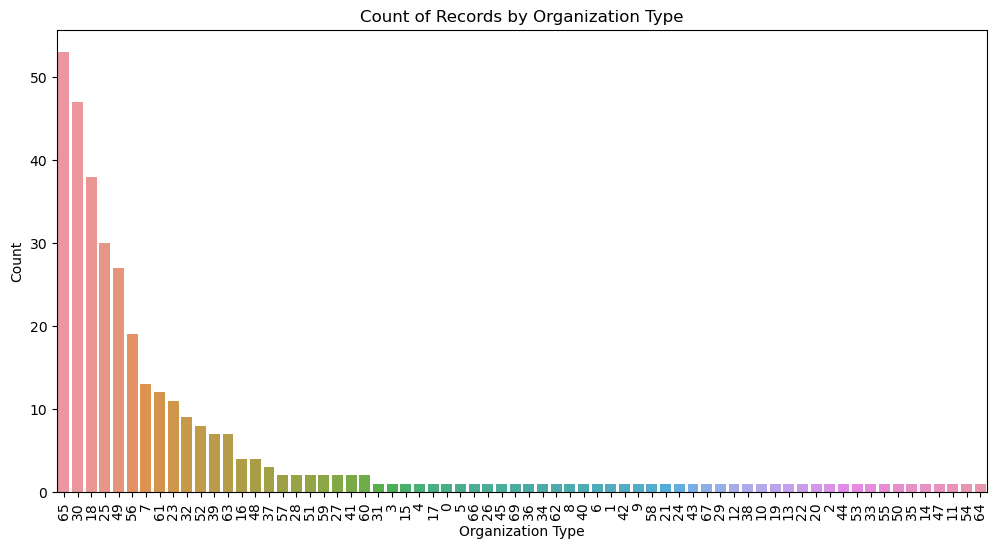

In [53]:
plt.figure(figsize=(12, 6))

# Sort the data by count in descending order
order = df_vis['Organization type'].value_counts().index

sns.countplot(data=df_vis, x='Organization type', order=order)
plt.title('Count of Records by Organization Type')
plt.xlabel('Organization Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

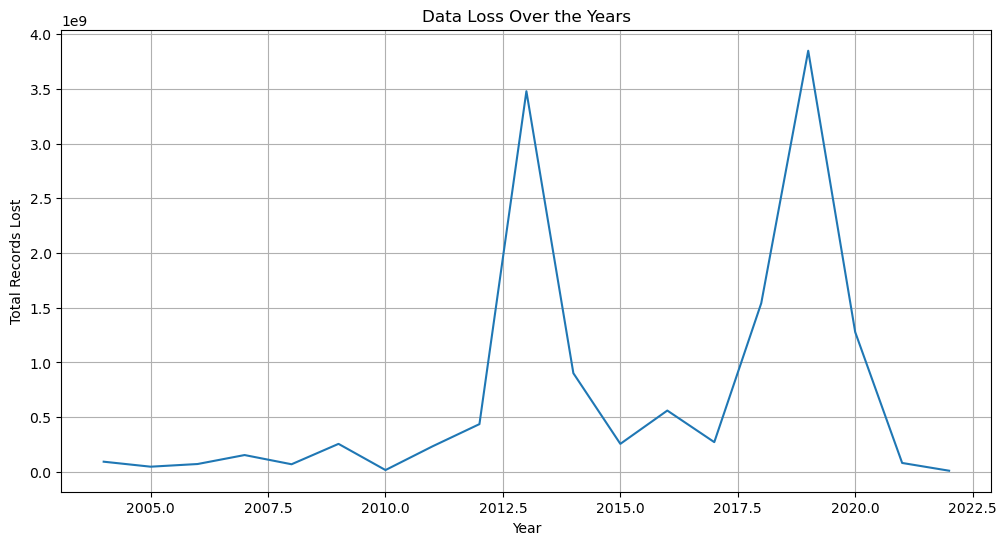

In [54]:
plt.figure(figsize=(12, 6))

# Group the data by year and calculate the total records lost in each year
data_lost_by_year = df_vis.groupby('Year')['Records'].sum().reset_index()

# Create a line plot to visualize data loss over the years
sns.lineplot(data=data_lost_by_year, x='Year', y='Records')
plt.title('Data Loss Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Records Lost')
plt.grid(True)
plt.show()